RGB to Haematoxylin-Eosin-DAB (HED) color space conversion followed by nuclei segmentation
and analysis

separate the immunohistochemical (IHC) staining from the hematoxylin counterstaining
The IHC staining expression of the FHL2 protein is here revealed with diaminobenzidine (DAB) which gives a brown color.

A. C. Ruifrok and D. A. Johnston, “Quantification of histochemical staining by color deconvolution,” Analytical and quantitative cytology and histology / the International Academy of Cytology [and] American Society of Cytology, vol. 23, no. 4, pp. 291-9, Aug. 2001. PMID: 11531144

https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_ihc_color_separation.html#sphx-glr-auto-examples-color-exposure-plot-ihc-color-separation-py

Try WSI datasets from here
https://zenodo.org/record/1485967#.Yd31lv7MKbh
https://www.wouterbulten.nl/blog/tech/peso-dataset-whole-slide-image-prosate-cancer/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread, imsave, imshow
from skimage import data, io, img_as_ubyte
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity
import pandas as pd
import pyclesperanto_prototype as cle
from PIL import Image
from PIL import Image, ImageOps

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def color_separate(ihc_rgb):

    #Convert the RGB image to HED using the prebuilt skimage method
    
    ihc_hed = rgb2hed(ihc_rgb)
    
    # Create an RGB image for each of the separated stains
    # Convert them to ubyte for easy saving to drive as an image
    
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_h = img_as_ubyte(hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1)))
    ihc_e = img_as_ubyte(hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1)))
    ihc_d = img_as_ubyte(hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1)))

    # Optional fun exercise of combining H and DAB stains into a single image with fluorescence look
    
    h = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1),
                          in_range=(0, np.percentile(ihc_hed[:, :, 0], 99)))
    d = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1),
                          in_range=(0, np.percentile(ihc_hed[:, :, 2], 99)))
   
    # Cast the two channels into an RGB image, as the blue and green channels
    # Convert to ubyte for easy saving as image to local drive
    
    zdh = img_as_ubyte(np.dstack((null, d, h))) #DAB in green and H in Blue

    return (ihc_h, ihc_e, ihc_d, zdh)

## Before I perform computations on an image, I like to look at in Python
### We do not need to do this for every image, but it is a good idea to spot check your work as you go!

## Read-in your image:

In [4]:
# read in raw image
ihc_rgb = imread("11.jpg")

## View your image

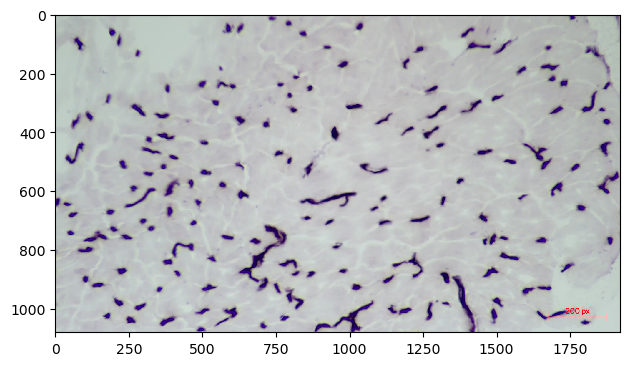

In [8]:
imshow(ihc_rgb)

## Perform image normalization 
### We don't need to do this here, but an image should be normalized before statistics are obtained from it

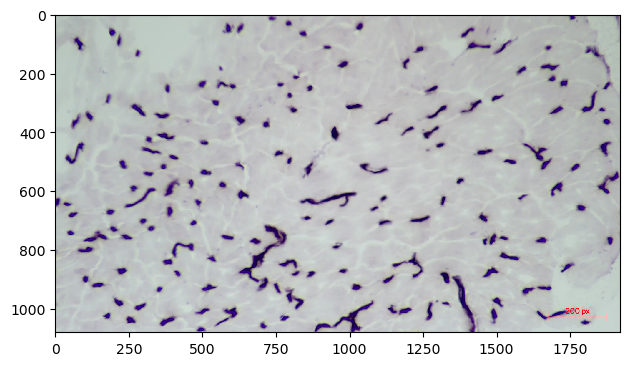

In [7]:
imshow(ihc_rgb / ihc_rgb.max())

In [9]:
H,E,D,HD = color_separate(ihc_rgb)

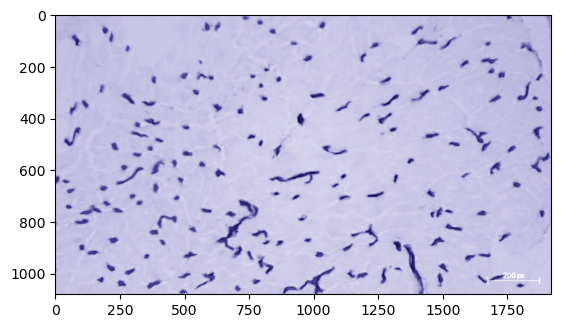

In [10]:
plt.imshow(H)

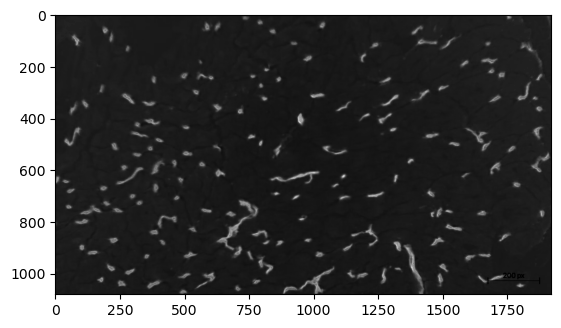

In [14]:
input_image = np.invert(H[:,:,2])
plt.imshow(input_image, cmap='gray')
plt.imsave('animal_number_invert.jpg', input_image)

In [16]:
# read in raw image
inverted_image = imread("animal_number_invert.jpg")

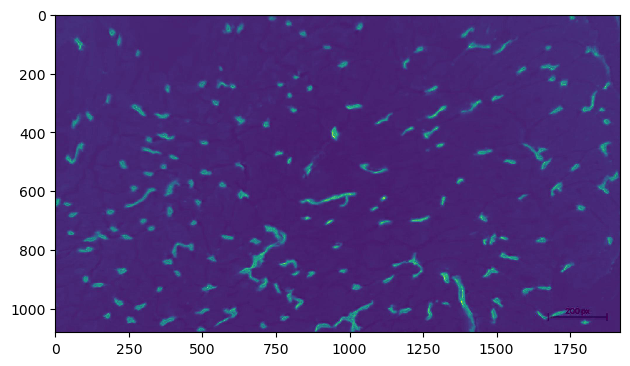

In [18]:
# show the original image
imshow(inverted_image)

## Look at the image shape.  
### This is another form of quality control to check on before performing calculations.

In [21]:
# image is 1080 pixels high, 1920 pixels wide, and has 3 channels.
inverted_image.shape

(1080, 1920, 3)

In [22]:
# ---------------------------------------------------------------------------------

# This is the process I follow to obtain area measurements off of a stained microscope image.

## 1. Read-in image

In [115]:
# read in raw image
ihc_rgb2 = imread("11.jpg")

## 2a. Convert the image from RGB to HED using Skimage

In [24]:
# Convert the RGB image to HED using the prebuilt skimage method
ihc_hed = rgb2hed(ihc_rgb2)

In [25]:
# Create an RGB image for each of the separated stains
# Convert them to ubyte for easy saving to drive as an image
    
null = np.zeros_like(ihc_hed[:, :, 0])
ihc_h = img_as_ubyte(hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1)))
ihc_e = img_as_ubyte(hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1)))
ihc_d = img_as_ubyte(hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1)))

In [26]:
h = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1), in_range=(0, np.percentile(ihc_hed[:, :, 0], 99)))
#d = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1), in_range=(0, np.percentile(ihc_hed[:, :, 2], 99)))

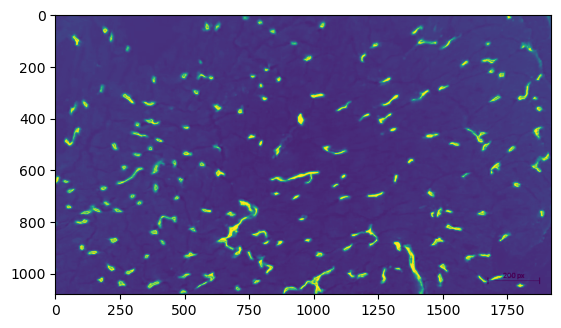

In [27]:
plt.imshow(h)

## 2b. Here is the way I more frequently convert an image to HED:

In [31]:
ihc_rgb3 = imread("11.jpg")

In [32]:
H,E,D,HD = color_separate(ihc_rgb3)

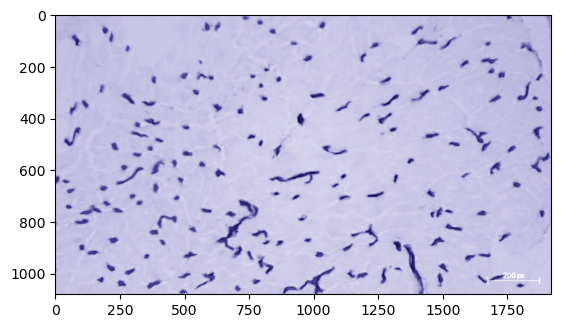

In [33]:
plt.imshow(H)

## 3. Invert the image.  
### We will be performing computations on the inverted image!

In [116]:
# Invert the image 
input_image = np.invert(H[:,:,2])

## 4. View the inverted image

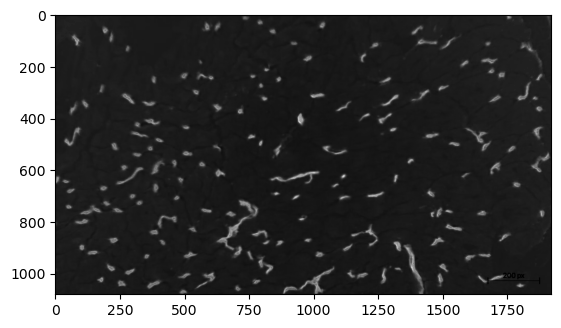

In [118]:
# View the image using a gray color map
plt.imshow(input_image, cmap='gray')

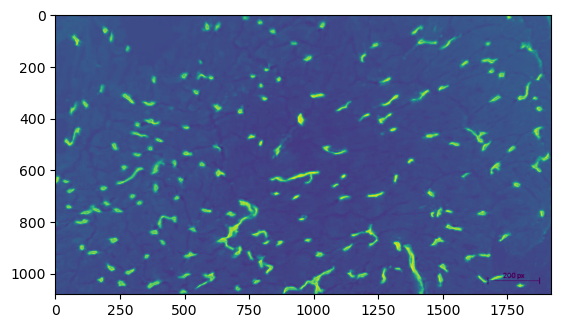

In [119]:
input_image = np.invert(H[:,:,1])

# View the original inverted image, no grayscale
plt.imshow(input_image)

### This code makes sure to use your GPU to perform calculations

In [120]:
device = cle.select_device('RTX')
print("Used GPU: ", device)

Used GPU:  <Apple M1 Pro on Platform: Apple (46 refs)>


/opt/anaconda3/lib/python3.9/site-packages/pyclesperanto_prototype/_tier0/_device.py:77: UserWarning: No OpenCL device found with RTX in their name. Using Apple M1 Pro instead.
  warnings.warn(f"No OpenCL device found with {name} in their name. Using {device.name} instead.")


In [121]:
input_gpu = cle.push(input_image)

### View the image again (sanity check)

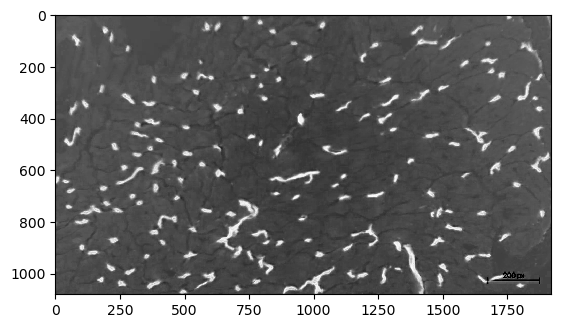

In [104]:
cle.imshow(input_image)
# Save your images
plt.imsave('H_img.jpg', H)

## 5. Segmentation using Voronoi-Otsu labeling

In [20]:
######################################################################################
# Segmentation using Voronoi-Otsu labeling                                           #
# For installation instructions of the package, please refer to the following link   #
# https://github.com/clEsperanto/pyclesperanto_prototype                             #
######################################################################################

In [114]:
# These variables are used to apply a mask to the stained image.  Play with these numbers under you 
# feel they represent what objects in the slide image you wish to measure.  I set both variables to 1, 
# the smallest amount they can set to.  This should be a very conservative approach.
sigma_spot_detection = 1
sigma_outline = 1

In [95]:
# Perform Voronoi-Otsu labeling
segmented = cle.voronoi_otsu_labeling(input_image, 
                                      spot_sigma = sigma_spot_detection, outline_sigma = sigma_outline)

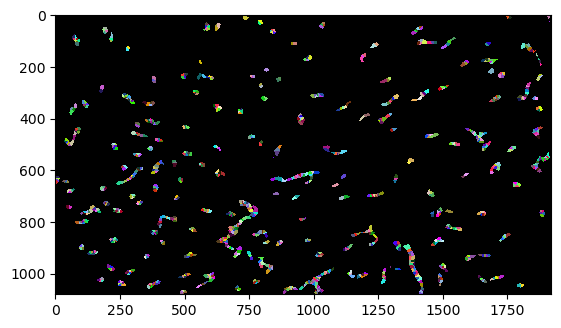

In [96]:
cle.imshow(segmented, labels = True)

## 6. Import "cell-like" data into a Pandas dataf

In [105]:
# Calculate the statistics of all labelled "cells"
statistics = cle.statistics_of_labelled_pixels(input_gpu, segmented) 

In [108]:
# Save the statistics in a Pandas dataframe
stat_table = pd.DataFrame(statistics)  

In [109]:
# view summary statistics of the dataframe
print(stat_table.describe())

             label  original_label   bbox_min_x   bbox_min_y  bbox_min_z  \
count  1093.000000     1093.000000  1093.000000  1093.000000      1093.0   
mean    547.000000      547.000000   899.212280   648.032043         0.0   
std     315.666227      315.666227   553.917358   293.927551         0.0   
min       1.000000        1.000000     0.000000     0.000000         0.0   
25%     274.000000      274.000000   388.000000   429.000000         0.0   
50%     547.000000      547.000000   830.000000   694.000000         0.0   
75%     820.000000      820.000000  1406.000000   898.000000         0.0   
max    1093.000000     1093.000000  1909.000000  1072.000000         0.0   

        bbox_max_x   bbox_max_y  bbox_max_z   bbox_width  bbox_height  ...  \
count  1093.000000  1093.000000      1093.0  1093.000000  1093.000000  ...   
mean    910.992676   659.399841         0.0    12.780421    12.367795  ...   
std     554.531921   293.265320         0.0     4.009753     3.491773  ...   
min

In [82]:
# view the nuber of datapoints in each column

print(label_stat_table.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093 entries, 0 to 1092
Data columns (total 37 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   label                                   1093 non-null   int64  
 1   original_label                          1093 non-null   int64  
 2   bbox_min_x                              1093 non-null   float32
 3   bbox_min_y                              1093 non-null   float32
 4   bbox_min_z                              1093 non-null   float32
 5   bbox_max_x                              1093 non-null   float32
 6   bbox_max_y                              1093 non-null   float32
 7   bbox_max_z                              1093 non-null   float32
 8   bbox_width                              1093 non-null   float32
 9   bbox_height                             1093 non-null   float32
 10  bbox_depth                              1093 non-null   floa

In [110]:
# Clean up the dataframe
stat_table.drop(columns = stat_table.columns[-10:], axis = 1,  inplace = True)

In [111]:
df = pd.DataFrame(stat_table)

In [64]:
# View the top 5 rows of data
df.head()

,label,original_label,bbox_min_x,bbox_min_y,bbox_min_z,bbox_max_x,bbox_max_y,bbox_max_z,bbox_width,bbox_height,...,mass_center_x,sum_intensity_times_y,mass_center_y,sum_intensity_times_z,mass_center_z,sum_x,centroid_x,sum_y,centroid_y,sum_z
0,1,1,0.0,642.0,0.0,4.0,653.0,0.0,5.0,12.0,...,1.291349,4422057.0,648.395447,0.0,0.0,51.0,1.378378,24003.0,648.729736,0.0
1,2,2,0.0,802.0,0.0,4.0,815.0,0.0,5.0,14.0,...,1.501491,6232171.0,808.218262,0.0,0.0,85.0,1.634615,42026.0,808.192322,0.0
2,3,3,0.0,983.0,0.0,3.0,992.0,0.0,4.0,10.0,...,1.108750,5156880.0,987.340637,0.0,0.0,43.0,1.264706,33568.0,987.294128,0.0
3,4,4,0.0,640.0,0.0,13.0,653.0,0.0,14.0,14.0,...,6.005363,11083164.0,646.097961,0.0,0.0,590.0,6.276596,60766.0,646.446838,0.0
4,5,5,0.0,635.0,0.0,16.0,646.0,0.0,17.0,12.0,...,8.201899,11531159.0,640.122070,0.0,0.0,815.0,8.316326,62739.0,640.193848,0.0


In [112]:
# Create a dataframe of the columns you wish to investigate further
stats = df[['label', 'area', 'min_intensity', 'max_intensity', 'mean_intensity']]

In [113]:
stats.head()

,label,area,min_intensity,max_intensity,mean_intensity
0,1,37.0,120.0,237.0,184.324326
1,2,52.0,117.0,201.0,148.288467
2,3,34.0,111.0,230.0,153.617645
3,4,94.0,116.0,235.0,182.489365
4,5,98.0,115.0,231.0,183.816330


In [90]:
# Calculate the sum of each column.  This should give us the total area stained
important_stats = stats.sum()
important_stats

label             597871.00000
area              109609.00000
min_intensity     126512.00000
max_intensity     248308.00000
mean_intensity    195281.21875
dtype: float64